# **INSTALLING AND IMPORTING LIBRARIES**

In [1]:
#Installing opendatasets for downloading dataset from Kaggle
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od #for downloading dataset from Kaggle
import os #for interacting with the operating system
import torch #for deep learning and tensor computation
import pandas as pd #for data manipulation and analysis
import numpy as np #for numerical operations and array handling
from torch.utils.data import Dataset, random_split, DataLoader #for creating datasets and managing data loading
from PIL import Image #for opening, manipulating, and saving image files
import torchvision.models as models #for pre-trained models and model architectures in computer vision
import matplotlib.pyplot as plt #for creating static, animated, and interactive visualizations
import torchvision.transforms as transforms #for image transformations and data augmentation
from sklearn.metrics import f1_score #for calculating the F1 score for classification models
import torch.nn.functional as F #for various neural network functions like activation, loss, etc.
import torch.nn as nn #for defining and training neural networks
from torchvision.utils import make_grid #for converting batches of images into grid format
from torchvision.datasets import ImageFolder #for loading datasets where images are organized into folders by class

# **DOWNLOADING AND ACCESSING DATASSET**

In [3]:
#Downloading desired dataset(lung x-ray images) from Kaggle
#You will need an account and API key
od.download("https://www.kaggle.com/tawsifurrahman/covid19-radiography-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saadur1998
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


In [22]:
#Accessing downloaded dataset
data_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
!rm -rf 'find -type d -name .ipynb_checkpoints'
classes = os.listdir(data_dir) #seeing available classes/folders
print(classes)

['Lung_Opacity', 'Viral Pneumonia', 'Normal.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'COVID.metadata.xlsx', 'COVID', 'Normal', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt']


# **TRANSFORIMNG IMAGES TO TENSOR AND RESIZING THEM**

In [23]:
#Loading the dataset(images) and applying the transformations(resize and convert to tensor) and storing the resulting dataset in the dataset variable.
transformations = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformations)

dataset
#You can see below, we have 42330 datapoints/images

Dataset ImageFolder
    Number of datapoints: 42330
    Root location: /content/covid19-radiography-database/COVID-19_Radiography_Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

# **VIEWING IMAGES AND DIVIDING DATASET INTO TRAIN AND VALIDATION SETS**

In [24]:
#Defining a funtion to see images and their label
def show_image(img, label):
  print('Label: ', dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

Label:  COVID


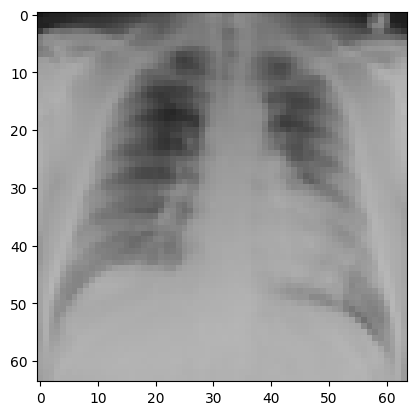

In [25]:
#Viewing randomely selected images
img, label = dataset[28]
show_image(img, label)

Label:  Normal


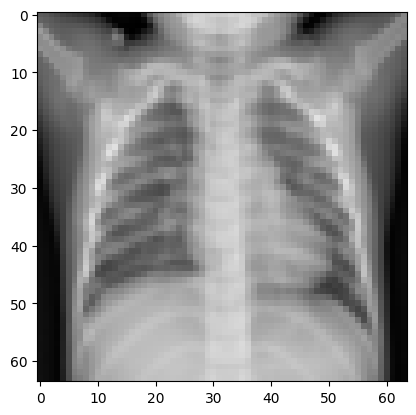

In [26]:
img, label = dataset[20150]
show_image(img, label)

Label:  Viral Pneumonia


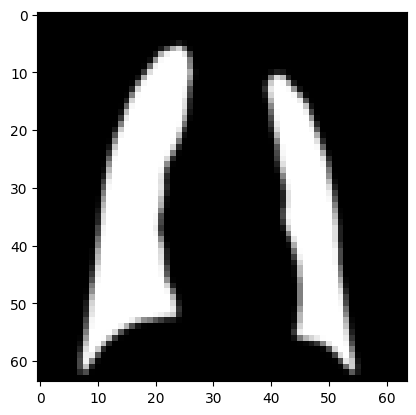

In [27]:
img, label = dataset[41344]
show_image(img, label)

In [28]:
#Setting a random seed to ensure reproducibility
#This ensures that we get the same train and test dataset when we run the code several times
random_seed = 23
torch.manual_seed(random_seed)

#Splitting the dataset into a training set (ds_train, 80% of the dataset) and a test set (ds_test, 20% of the dataset)
ds_train, ds_test = random_split(dataset, [33864, 8466])
len(ds_train), len(ds_test)

(33864, 8466)

In [29]:
batch_size = 128 #load training and validation data in batches of 64, batchsizes are usually kept as powers of 2

#Efficiently loading data in batches for training or validation.
#shuffle=True: shuffels the dataset at the beginning of each epoch to ensure that the model doesn't learn patterns based on the order of the data
#pin_memory = True: optimizes the transfer of data from CPU to GPU
dl_train = DataLoader(ds_train, batch_size, shuffle=True, num_workers=3, pin_memory=True)
dl_valid = DataLoader(ds_test, batch_size, num_workers=3, pin_memory=True)

In [30]:
#Defining a function to view a bacth of images
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(14,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

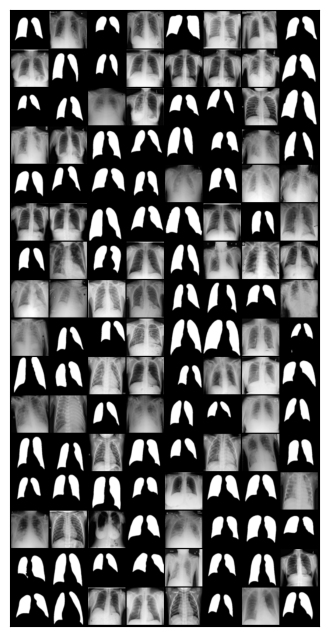

In [31]:
#Viewing a batch
show_batch(dl_train)

# **MOVING/LOADING DATA TO APPROPRIATE DEVICE**

In [32]:
#Defiing a function to check if a GPU (CUDA-enabled device) is available.
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

#Defining a function to move the data to the specified device (either CPU or GPU).
def to_device(data, device):
  if isinstance(data, (list,tuple)): #check if the data is a list or tuple
    return [to_device(x, device) for x in data] #recursively move each element to the device.
  return data.to(device, non_blocking=True) #else move the single data element to the specified device, non_blocking=True for asynchronous data transfer

#Creating a class wrapper to automatically transfer data to the specified device (CPU or GPU)
class DeviceDataLoader():
  def __init__(self, dl, device): #constructor method
    self.dl = dl
    self.device = device

  #Iterateing through the batches in the data loader and moveing each batch to the specified device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  #Returing the number of batches present
  def __len__(self):
    return len(self.dl)

In [33]:
#Checking if a GPU (CUDA-enabled device) is available
device = get_default_device()
device

device(type='cuda')

In [34]:
#Wrap the original data loaders in the DeviceDataLoader class
#This ensures that the training and validation data is automatically moved to the correct device (either CPU or GPU) when iterated over.
dl_train = DeviceDataLoader(dl_train, device)
dl_valid = DeviceDataLoader(dl_valid, device)

# **Base Class for Image Classification with Accuracy and Loss Calculation**

In [35]:
#Defining a function to compute accuracy
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)  #get the predicted class by finding the index of the maximum output value
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#Creating Base class for image classification, inheriting from nn.Module
#This defines methods for training, validating, and reporting model performance.
class ImageClassificationBase(nn.Module):

  # Defining Method to compute the loss for training steps
  def training_steps(self, batch):
    images, labels = batch
    out = self(images)  #forward pass through the model
    #A forward pass refers to the process where input data is passed through a neural network. Data flows from the input layer through the hidden layers and finally to the output layer.
    #During this process, computations are performed based on the model’s current parameters (such as weights and biases), and the network generates predictions or classifications.
    loss = F.cross_entropy(out, labels)  #calculate the loss using cross-entropy
    return loss

  #Defining Method to compute the loss and accuracy for validation steps
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)  #forward pass through the model
    loss = F.cross_entropy(out, labels)  #calculate the loss using cross-entropy
    acc = accuracy(out, labels)  #calculate the accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  #Defining Method to aggregate validation results at the end of an epoch
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs] #extract the losses from each validation step in the epoch
    epoch_loss = torch.stack(batch_losses).mean() #calculate the mean

    batch_accs = [x['val_acc'] for x in outputs] #extract the accuracies from each validation step in the epoch
    epoch_acc = torch.stack(batch_accs).mean() #clculate the mean
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  #Defining Method to print the results at the end of each epoch
  def epoch_end(self, epoch, result):
    print(f'Epoch [{epoch}], last_lr: {result["lrs"][-1]:.5f}, train_loss: {result["train_loss"]:.4f}, val_loss: {result["val_loss"]:.4f}, val_acc: {result["val_acc"]:.4f}')


# **Building a Convolutional Neural Network with Residual Connections (RasNet9)**

In [36]:
#Defiing a function to create a convolutional block with Conv2d, BatchNorm, ReLU, and optional MaxPool2d
#This function defines a series of layers that are commonly used in convolutional neural networks (CNNs) to learn feature representations from images.
def conv_block(in_channels, out_channels, pool=False):
  #Defining layers: Conv2d -> BatchNorm -> ReLU
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  #Applies a 2D convolution to the input, transforming it into a feature map with 'out_channels' number of filters.
            nn.BatchNorm2d(out_channels),  #Normalizes the feature maps along each channel to have a mean of 0 and a standard deviation of 1, improving training speed and stability.
            nn.ReLU(inplace=True)]  #Rectified Linear Unit sets negative values to zero and keeps positive values unchanged, introducing non-linearity.


  #If pool=True: Reduces the spatial dimensions (height and width) of the feature maps, typically by taking the maximum value from 2x2 or 3x3 regions.
  if pool:
    layers.append(nn.MaxPool2d(2))  #MaxPool2d applies 2x2 max pooling to reduce the spatial dimensions by half

  # Return the entire block as a Sequential module, which allows stacking layers sequentially in the model
  return nn.Sequential(*layers)

# RasNet9 class inherits from ImageClassificationBase and defines a custom architecture
# This class defines a custom convolutional neural network (CNN) architecture with multiple convolutional layers, residual connections, and a classifier.
class RasNet9(ImageClassificationBase):

  # Initialize the model with input channels and number of output classes
  # The constructor sets up the network architecture, initializing convolutional layers, residual blocks, and the classifier.
  def __init__(self, in_channels, num_classes):
    super().__init__()

    # Define the first set of convolutional layers and residual block
    self.conv1 = conv_block(in_channels, 64)  # First convolution block (input channels -> 64 output channels)
    self.conv2 = conv_block(64, 128, pool=True)  # Second convolution block (64 -> 128 output channels, with max pooling)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))  # Residual block with two convolution layers

    # Define the second set of convolutional layers and residual block
    self.conv3 = conv_block(128, 256, pool=True)  # Third convolution block (128 -> 256 output channels, with max pooling)
    self.conv4 = conv_block(256, 512, pool=True)  # Fourth convolution block (256 -> 512 output channels, with max pooling)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))  # Residual block with two convolution layers

    # Define the third set of convolutional layers and residual block
    self.conv5 = conv_block(512, 1024, pool=True)  # Fifth convolution block (512 -> 1024 output channels, with max pooling)
    self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))  # Residual block with two convolution layers

    # Define the classifier layers: MaxPool2d, Flatten, Dropout, and Linear layer
    # MaxPool2d reduces the spatial size of the output, Flatten converts the 2D feature map to a 1D vector,
    # Dropout helps to prevent overfitting, and Linear maps the features to the final class predictions.
    self.classifier = nn.Sequential(nn.MaxPool2d(4),  # Apply max pooling to reduce dimensions
                                    nn.Flatten(),  # Flatten the output into a 1D vector
                                    nn.Dropout(0.2),  # Apply dropout for regularization (20% probability to drop units)
                                    nn.Linear(1024, num_classes))  # Linear layer to output final class predictions

  # Forward pass through the network
  # The forward method defines how the input is passed through the network, from the convolutional layers to the classifier.
  def forward(self, xb):
    # Pass input through the first set of conv layers and add residual connection
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out  # Add residual connection (output + input of this block)

    #Pass through the second set of conv layers and add residual connection
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out  # Add residual connection (output + input of this block)

    #Pass through the third set of conv layers and add residual connection
    out = self.conv5(out)
    out = self.res3(out) + out  # Add residual connection (output + input of this block)

    #Pass the output through the classifier layers and return the final result
    out = self.classifier(out)
    return out  # Return the final output (predicted class probabilities)


In [37]:
model = to_device(RasNet9(3,4), device)
model

RasNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss = model.training_steps(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [39]:
history = [evaluate(model, dl_valid)]
history

[{'val_loss': 1.3947712182998657, 'val_acc': 0.16956882178783417}]

In [40]:
epochs = 10
max_lr = 0.002
grad_clip = 0.1
weight_decay = 5e-4
opt_func = torch.optim.Adam

In [41]:
%%time
history += fit_one_cycle(epochs, max_lr, model, dl_train, dl_valid,
                  weight_decay, grad_clip, opt_func)

Epoch [0], last_lr: 0.00056, train_loss: 0.8797, val_loss: 0.7671, val_acc: 0.7218
Epoch [1], last_lr: 0.00152, train_loss: 0.6829, val_loss: 0.8866, val_acc: 0.6470
Epoch [2], last_lr: 0.00200, train_loss: 0.5949, val_loss: 0.5386, val_acc: 0.7928
Epoch [3], last_lr: 0.00190, train_loss: 0.5419, val_loss: 1.2886, val_acc: 0.5381
Epoch [4], last_lr: 0.00162, train_loss: 0.4975, val_loss: 0.5610, val_acc: 0.7935
Epoch [5], last_lr: 0.00122, train_loss: 0.4465, val_loss: 0.5356, val_acc: 0.7842
Epoch [6], last_lr: 0.00078, train_loss: 0.4071, val_loss: 0.4583, val_acc: 0.8346
Epoch [7], last_lr: 0.00038, train_loss: 0.3508, val_loss: 0.5109, val_acc: 0.8184
Epoch [8], last_lr: 0.00010, train_loss: 0.2831, val_loss: 0.3979, val_acc: 0.8521
Epoch [9], last_lr: 0.00000, train_loss: 0.2123, val_loss: 0.4039, val_acc: 0.8555
CPU times: user 3min 35s, sys: 3min, total: 6min 36s
Wall time: 14min 4s


In [42]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracies')
  plt.title('Accuracies vs No. of epochs')

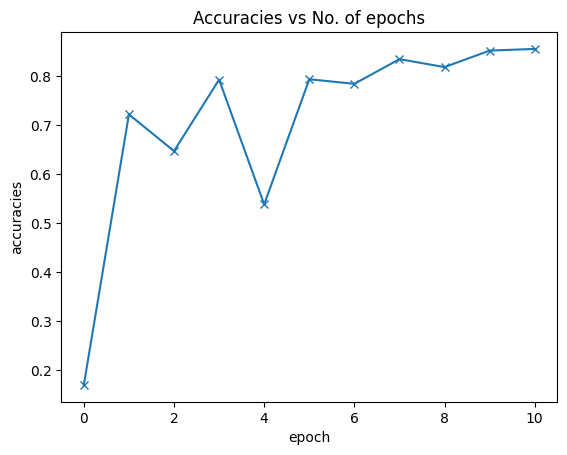

In [43]:
plot_accuracies(history)

In [44]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs No. of epochs')

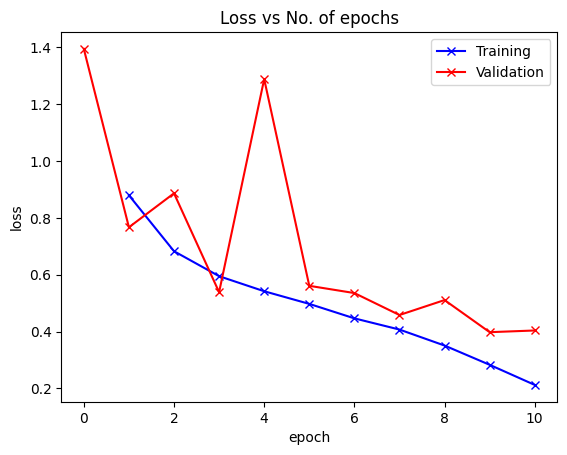

In [45]:
plot_losses(history)

In [46]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs',[]) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch No.')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate vs Batch No.')

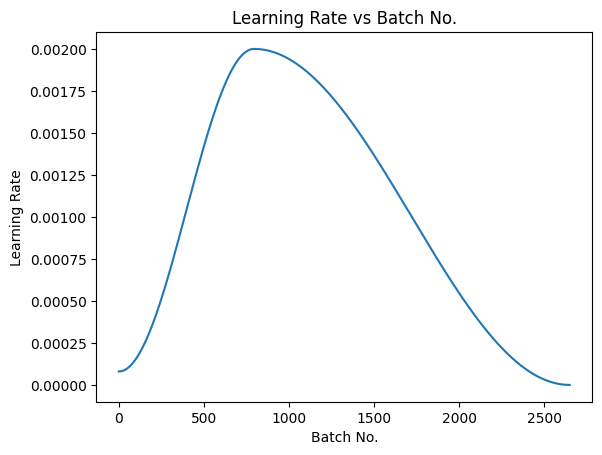

In [47]:
plot_lrs(history)

In [48]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  prob, preds = torch.max(yb, dim = 1)
  return dataset.classes[preds[0].item()]

Label:  Normal , Predicted:  Normal


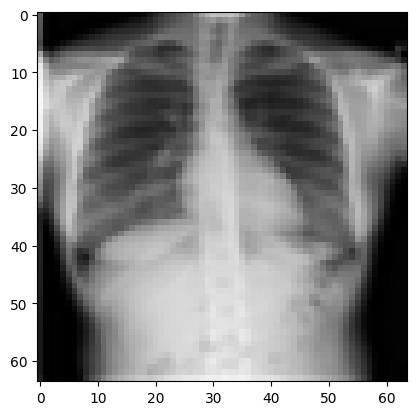

In [ ]:
img, label = ds_test[90]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  Lung_Opacity , Predicted:  Lung_Opacity


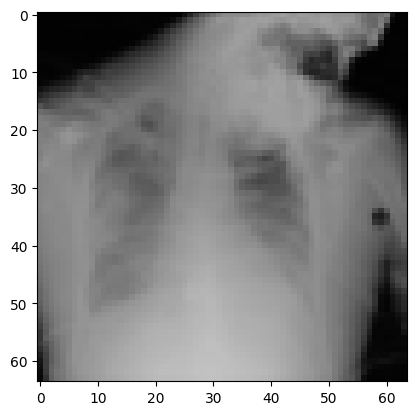

In [ ]:
img, label = ds_test[987]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  Viral Pneumonia , Predicted:  Viral Pneumonia


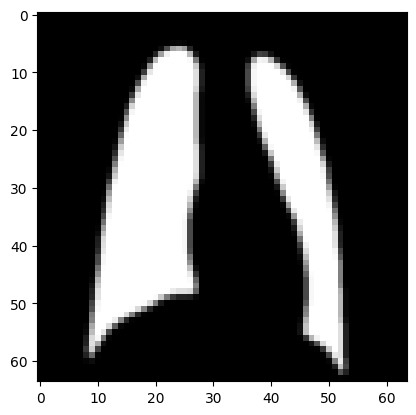

In [ ]:
img, label = ds_test[2067]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  Normal , Predicted:  Normal


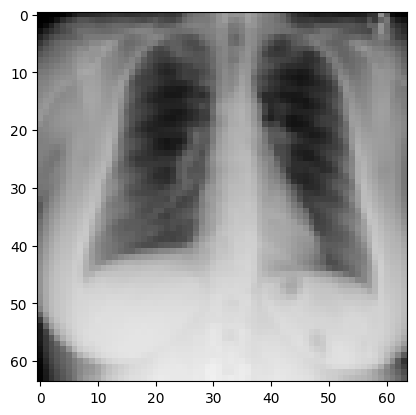

In [ ]:
img, label = ds_test[7056]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  COVID , Predicted:  COVID


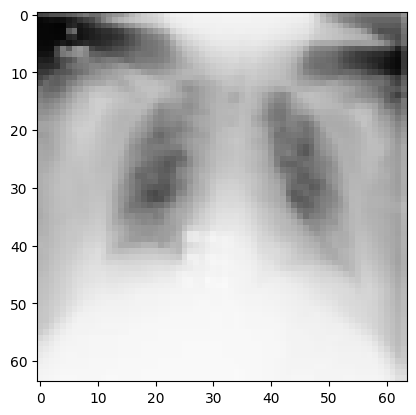

In [ ]:
img, label = ds_test[5438]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  Viral Pneumonia , Predicted:  COVID


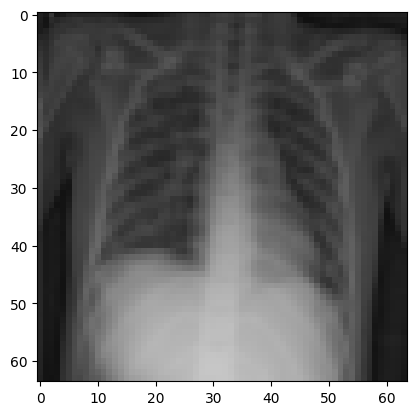

In [ ]:
img, label = ds_test[141]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  COVID , Predicted:  COVID


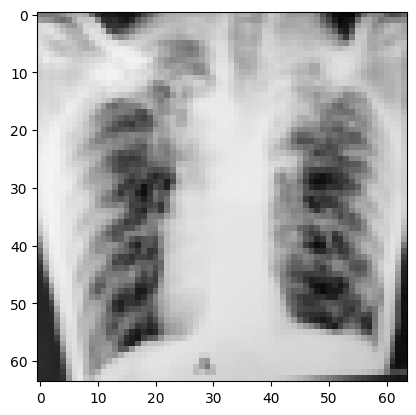

In [ ]:
img, label = ds_test[673]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))

Label:  Normal , Predicted:  Normal


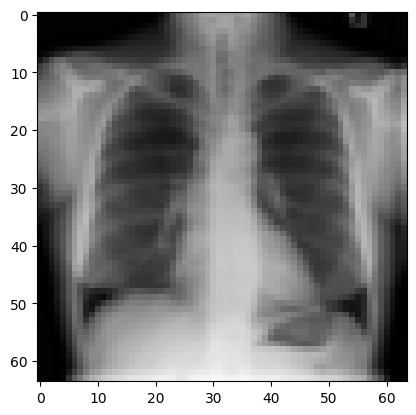

In [ ]:
img, label = ds_test[4890]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',dataset.classes[label],', Predicted: ',predict_image(img,model))